<a href="https://colab.research.google.com/github/jayaemekar/CSCI-611-AppiledMachineLearning/blob/main/PathToHerdImmunity_ProphetModel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path To Herd Immunity -Covid 19 Prediction using Prophet
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 Path to Herd Immunity via
Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


# NOTEBOOK INCLUDES
 1. Data Preparation including cleaning and Missing data
 2. Exploratory data analysis on complete world vaccination data 
 3. Exploration of Prophet 



# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
rcParams["figure.figsize"] = 12,8


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Import geopandas for ploting of world map

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 8.0MB/s 
     |████████████████████████████████| 15.3MB 267kB/s 
     |████████████████████████████████| 6.5MB 31.1MB/s 


In [ ]:
#import geo data
import geopandas as gpd

# Load the data 
1. Take the latest data(updated on daily basis) in our world in Data github repository

In [ ]:
covid_data_url = ''
covid_dataRaw_df = ''
covid_dataRaw_df_dimensions = ''
covid_dataRaw_locations = ''
covid_latest_date = ''

covid_data_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
covid_dataRaw_df = pd.read_csv(covid_data_url, error_bad_lines=False)

# RAW DATA PARAMETERS
covid_dataRaw_df_dimensions = covid_dataRaw_df.shape
covid_dataRaw_locations = covid_dataRaw_df.location.unique()
covid_dataRaw_df['date'] = pd.to_datetime(covid_dataRaw_df['date'])
covid_dates = covid_dataRaw_df['date'].to_list()
covid_latest_date = covid_dataRaw_df['date'].to_list()[-1].strftime('%b %d, %Y')

## Shape of data

In [ ]:
#Shape of data
covid_dataRaw_df.shape

(86896, 59)

##Check how many countries are present in the dataset

In [ ]:
#Check how many countries are present in the dataset
covid_dataRaw_df['location'].nunique()

219

In [ ]:
#check for all missing values in data
covid_dataRaw_df.isnull().sum()

iso_code                                     0
continent                                 4183
location                                     0
date                                         0
total_cases                               2232
new_cases                                 2234
new_cases_smoothed                        3235
total_deaths                             11960
new_deaths                               11802
new_deaths_smoothed                       3235
total_cases_per_million                   2689
new_cases_per_million                     2691
new_cases_smoothed_per_million            3687
total_deaths_per_million                 12404
new_deaths_per_million                   12246
new_deaths_smoothed_per_million           3687
reproduction_rate                        16862
icu_patients                             78056
icu_patients_per_million                 78056
hosp_patients                            75886
hosp_patients_per_million                75886
weekly_icu_ad

## Print basic statics of data

In [ ]:
# Print basic statics of data
cm = sns.light_palette("blue", as_cmap=True)
covid19_stats = covid_dataRaw_df.describe().style.background_gradient(cmap=cm)
display(covid19_stats)

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
count,84664.000000,84662.000000,83661.000000,74936.000000,75094.000000,83661.000000,84207.000000,84205.000000,83209.000000,74492.000000,74650.000000,83209.000000,70034.000000,8840.000000,8840.000000,11010.000000,11010.000000,802.000000,802.000000,1395.000000,1395.000000,39642.000000,39345.000000,39345.000000,39642.000000,45462.000000,45462.000000,43692.000000,43099.000000,10176.000000,9486.000000,7103.000000,8637.000000,16255.000000,10176.000000,9486.000000,7103.000000,16255.000000,73644.000000,86324.000000,80881.000000,78226.000000,77334.000000,77788.000000,78579.000000,53480.000000,79159.000000,80351.000000,62003.000000,61090.000000,39767.000000,72214.000000,82464.000000,79036.000000
mean,856334.882040,5929.960136,5909.639958,23646.037312,140.506365,124.584843,10465.895801,74.906470,75.011972,232.313072,1.516847,1.347171,1.016523,1093.665385,26.696648,4846.387829,175.114754,282.998218,21.371049,3797.718738,114.899735,43853.369658,6167317.375575,238.622813,1.912016,41931.312591,1.809696,0.089000,158.245010,16264736.678459,9894312.609846,5184152.082782,441954.410559,234969.692648,14.552246,10.153391,5.554746,2847.489080,58.686694,128099576.386358,351.262210,30.524193,8.775349,5.558365,19148.620788,13.352203,257.869544,7.822528,10.524779,32.660250,50.903886,3.029610,73.168189,0.727104
std,5914187.287463,37293.716340,36606.072173,140024.757629,767.594790,703.146103,19963.370294,176.508546,149.460021,407.006389,3.974432,2.941792,0.356090,3026.658440,27.941704,12415.351021,217.021423,589.157751,36.938161,11382.949628,225.108300,162373.461670,27778837.923343,528.599029,5.502712,148582.467884,4.528459,0.097378,857.836805,75427010.567758,42056699.198132,20819357.755547,1772290.072688,1209354.502912,22.749215,14.436203,10.045968,4597.482429,21.622812,689491583.404058,1709.948655,9.116742,6.224545,4.249445,19837.972036,19.943649,118.790358,3.981427,10.404151,13.474315,31.762556,2.462803,7.549430,0.150072
min,1.000000,-74347.000000,-6223.000000,1.000000,-1918.000000,-232.143000,0.001000,-2153.437000,-276.825000,0.001000,-76.445000,-10.921000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-874799.000000,0.000000,0.000000,-74.942000,0.000000,0.000000,0.000000,1.300000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,809.000000,0.137000,15.100000,1.144000,0.526000,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000
25%,970.000000,2.000000,7.000000,46.000000,0.000000,0.000000,207.876500,0.196000,1.182000,6.862750,0.000000,0.000000,0.850000,31.000000,4.523000,114.000000,23.028250,8.791500,1.909000,48.983000,9.064500,1451.000000,128008.000000,11.566000,0.126000,1482.000000,0.124000,0.016000,7.700000,67617.250000,56860.750000,28500.500000,3416.000000,955.000000,1.190000,0.990000,0.485000,335.000000,44.440000,2416664.000000,36.2530

#Data Processing

## Preprocess raw data

1. convert the "Date" column into DATETIME data type
2. Remove small location where population is less than 1000000
3. Set 'location' column as row index
4. Re-scale 'total_vaccinations_per_hundred' and 'people_fully_vaccinated_per_hundred' to per million

In [ ]:
min_population = 1000000

preProcessed_covid_df = covid_dataRaw_df.copy()
# convert the "Date" column into DATETIME data type
preProcessed_covid_df['date'] = pd.to_datetime(preProcessed_covid_df['date'])

# Remove small location where population is less than 1000000
preProcessed_covid_df = preProcessed_covid_df[preProcessed_covid_df.population >= min_population]

# Set 'location' column as row index
preProcessed_covid_df.set_index('location', inplace=True)

#Re-scale 'total_vaccinations_per_hundred' and 'people_fully_vaccinated_per_hundred' to per million
preProcessed_covid_df['total_vaccinations_per_hundred'] *= 10000
preProcessed_covid_df['people_fully_vaccinated_per_hundred'] *= 10000
preProcessed_covid_df.rename(columns = {"total_vaccinations_per_hundred":"total_vaccinations_per_million",
                 "people_fully_vaccinated_per_hundred":"people_fully_vaccinated_per_million"}, inplace=True)

##Create Dataset to be used

1. Created new columns "perCapita_daily_columns" and "perCapita_cumulative_columns" using the exising column
2. Created dataframes for "covid_perCapita_daily_df" and "covid_perCapita_cumulative_df"


In [ ]:
#Create Dataset to be used
#Created new columns "perCapita_daily_columns" and "perCapita_cumulative_columns" using the exising column
perCapita_daily_columns = ["date","new_cases_smoothed_per_million", "new_deaths_smoothed_per_million",
                           "new_vaccinations_smoothed_per_million"]
perCapita_cumulative_columns = ["date", "total_cases_per_million", "total_deaths_per_million",
                                "total_vaccinations_per_million", "people_fully_vaccinated_per_million"]

# Created dataframes for "covid_perCapita_daily_df" and "covid_perCapita_cumulative_df"
covid_perCapita_daily_df = preProcessed_covid_df[perCapita_daily_columns]
covid_perCapita_cumulative_df = preProcessed_covid_df[perCapita_cumulative_columns]

# Exploratory Data Analysis for vaccination rates

## Relation-People fully vaccinated per hundred vs Contient
Plot graph for people fully vaccinated per hundred vs Contient

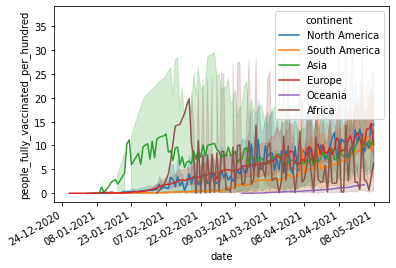

In [ ]:
#use lineplot to plot data 
graph = sns.lineplot(data= covid_dataRaw_df.sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='continent')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
graph.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation = 90)
plt.gcf().autofmt_xdate()
plt.show()

We can see as more and more time passing by various countries are progressing on vaccinated people 


1.   We see a good linear progress in North America Graph
2.   People are hardly vaccinated in Oceania 
3.   Graph for Asia, Europe and North America is more or less close to each other





##Relation-people fully vaccinated per hundred vs life_expectancy

Plot a graph to show the relation between people fully vaccinated per hundred vs life_expectancy

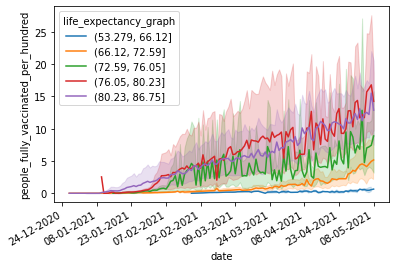

In [ ]:
#Plot a graph to show the relation between people fully vaccinated per hundred vs life_expectancy
covid_dataRaw_df['life_expectancy_graph'] = pd.qcut(covid_dataRaw_df['life_expectancy'],q=5)
graph = sns.lineplot(data=covid_dataRaw_df.sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='life_expectancy_graph')
graph.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
plt.xticks(rotation = 90)
plt.gcf().autofmt_xdate()
plt.show()

* We can observe that as people are getting vaccinated life 
expectancy is also linearly increasing 
* Life expectancy is the average time a person lives 
* We can observe that in all cases are time is passing by and people started to get vaccine life expectancy is increasing 

##Relation- people fully vaccinated per hundred vs population
Plot a graph to show the relation between people fully vaccinated per hundred vs population

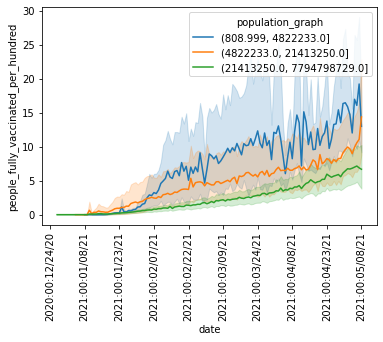

In [ ]:
#Plot a graph to show the relation between people fully vaccinated per hundred vs population
covid_dataRaw_df['population_graph'] = pd.qcut(covid_dataRaw_df['population'],q=3)
graph = sns.lineplot(data=covid_dataRaw_df.sort_values(by='date'), x='date', 
                     y='people_fully_vaccinated_per_hundred',hue='population_graph')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

We can observe that 
* Population is increasing as days are passing and as number of vaccinated people are getting increased 
* We have grouped in three groups population before and as days are going by 



##Relation -people fully vaccinated per hundred vs country
Plot a graph to show the relation between people fully vaccinated per hundred vs some of the main countries

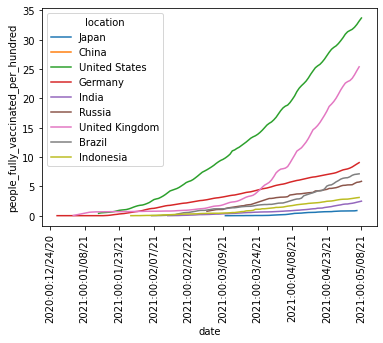

In [ ]:
graph = sns.lineplot(data=covid_dataRaw_df[covid_dataRaw_df['iso_code'].isin(['GBR','IDN','BRA','RUS','DEU','JPN','IND','USA','CHN'])]
                     .sort_values(by='date'), x='date', y='people_fully_vaccinated_per_hundred',hue='location')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

Randomly decided on 8 countries and checked the vaccination rate
* For United States it is getting increased day by day
* The least vaccination is in Japan 
* Russia had and average vaccinated rate 



##Overall plot for people_fully_vaccinated_per_hundred 

overall plot for people_fully_vaccinated_per_hundred 

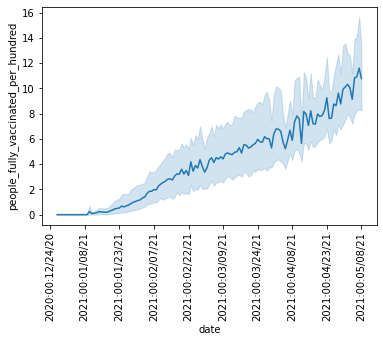

In [ ]:
#overall plot for people_fully_vaccinated_per_hundred 
graph = sns.lineplot(data=covid_dataRaw_df.sort_values(by="date"), x="date",
                     y="people_fully_vaccinated_per_hundred")
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)
plt.show()

We have plotted the overall plot here:
* Overall the number of vaccinated people in the world is increasing day by day and we have a linear increase in graph



## Map plot based on country map

In [ ]:
#we will read in data for plotting map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [ ]:
#as we already have continent in our data we will drop that column
del world['continent']
#We will join both the data for covid and world map and join it on iso_code
mapped = world.set_index('iso_a3').join(covid_dataRaw_df.set_index('iso_code')).reset_index()

In [ ]:
#function to create map graph
def graph_world(feature):
    #whichever data we wish to map we will send in feature
    to_be_mapped = feature
    vmin, vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(25,25))

    mapped.plot(column=to_be_mapped, cmap='inferno', linewidth=0.8, ax=ax, edgecolors='0.8')
    ax.set_title('x', fontdict={'fontsize':30})
    ax.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal')

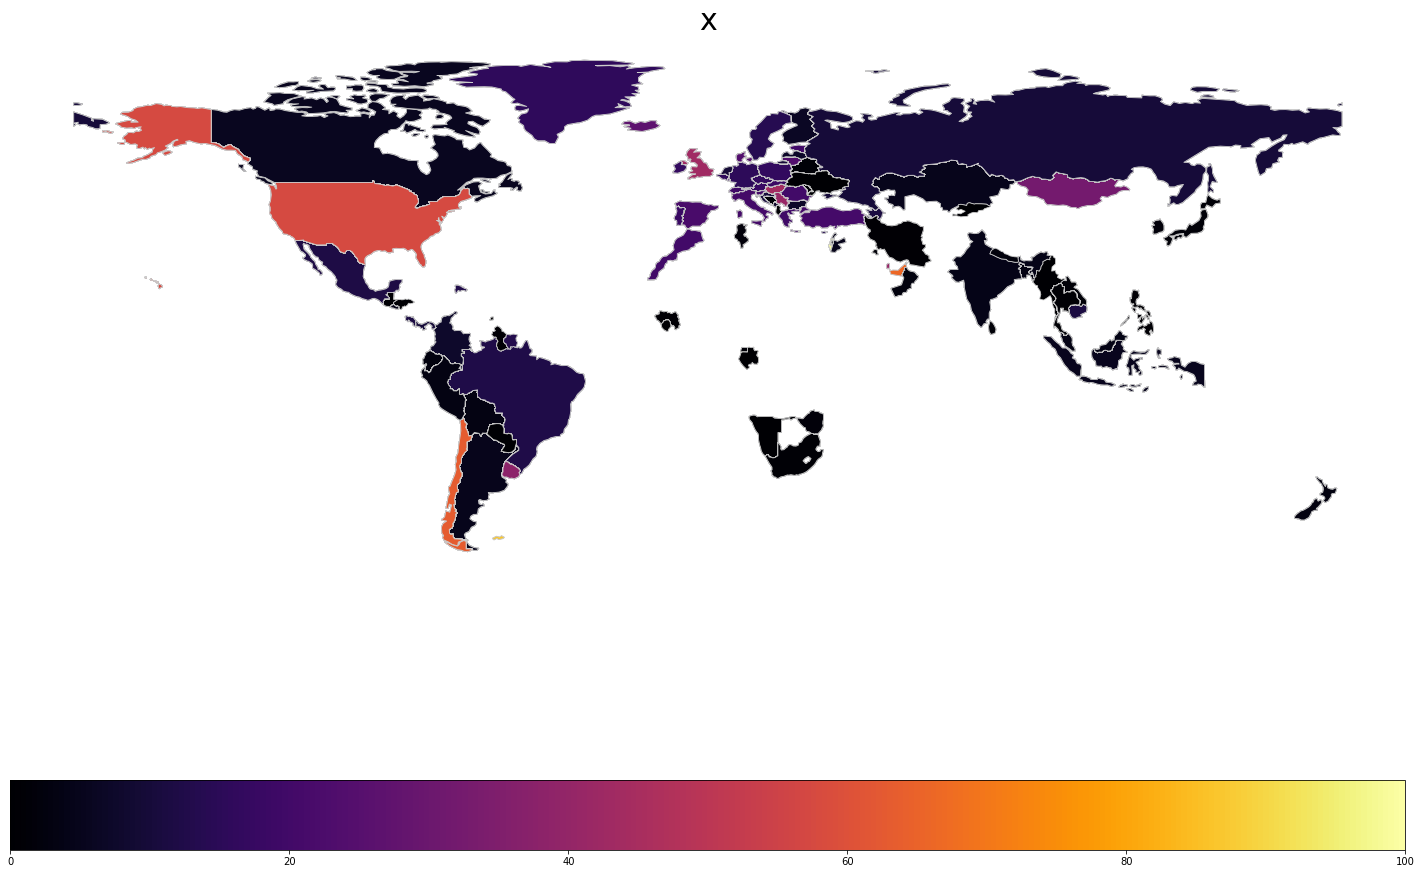

In [ ]:
#we will send data for full vaccinated people per hundred
graph_world('people_fully_vaccinated_per_hundred')

#Prediction of vactionation rate

Find the top five country which are having the maximum vaccination in the world

In [ ]:
top_5_vacc = list(covid_dataRaw_df[(~covid_dataRaw_df['people_fully_vaccinated_per_hundred'].isna())&
                            (covid_dataRaw_df['date']=='2021-03-28')].sort_values
                            (by='people_fully_vaccinated_per_hundred',ascending=False)
                            .head(5)['iso_code'])
print("Top 5 vaccinated countries :\n",top_5_vacc)

Top 5 vaccinated countries :
 ['GIB', 'ISR', 'CHL', 'USA', 'JEY']


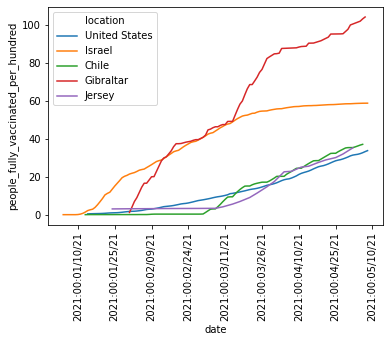

In [ ]:
#Top five countries in the world with highest vaccination rates
graph = sns.lineplot(data=covid_dataRaw_df[covid_dataRaw_df['iso_code'].isin(top_5_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='location')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 15))
graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

 This graph shows the top five countries with highest vaccination rate
 1. Gibraltar at the top for vaccination rate
 2. Israel is at the second position
 




##Predict vaccination Rate for Top five countries

###Function to forecast vaccination and infection rate 

1. Define Prophet Model
2. Fit the model
3. Define the period for which we want a prediction
4. Use the model to make a forecast
5. Summarize the forecast
6. Plot the forecast

In [ ]:
def fcast(cntry, isVaccRate):
    p = ''
    if isVaccRate == "true":
      p = covid_dataRaw_df[covid_dataRaw_df['iso_code'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
    else :
      p = covid_dataRaw_df[covid_dataRaw_df['iso_code'].isin([cntry])].sort_values(by="date")[['date',"new_cases_smoothed_per_million"]]
   
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%01d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2021-%12d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(5))
    # plot forecast
    
    model.plot(forecast)
    if isVaccRate == "true":
      plt.ylim(0, 100)
    else:
      plt.ylim(0, 2000)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

#Forecast for vaccination and infection rate for top 5 countries

##Forecast for Gibraltar

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01 -49.420955  -50.752359  -48.126338
1 2021-01-01 -49.420955  -50.759823  -48.100717
2 2021-02-01   5.261849    3.945102    6.611947
3 2021-02-01   5.261849    3.959881    6.584521
4 2021-03-01  41.403595   40.106202   42.743340


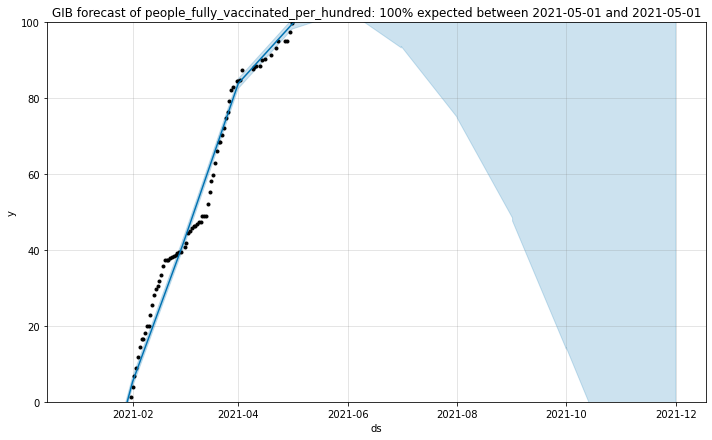

In [ ]:
#Forecast for Gibraltar for vaccination rate
fcast('GIB', "true")

Prediction for Gibratar
1. Gibratar is fully vaccinated by April 2021
2. There is no infection data present for Gibratar, hence we are not able to predict infection rate



##Forecast For ISRAEL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  -0.210479   -0.379309   -0.041669
1 2021-01-01  -0.210479   -0.373975   -0.029638
2 2021-02-01  21.722605   21.541999   21.900344
3 2021-02-01  21.722605   21.541518   21.892613
4 2021-03-01  40.107879   39.930944   40.271936


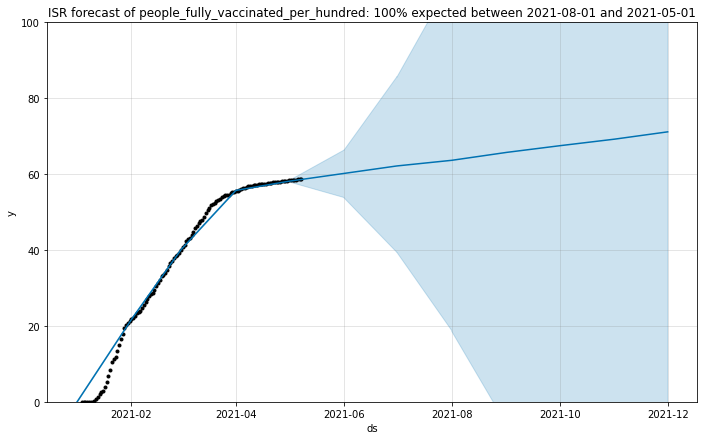

In [ ]:
#Forecast for Israel for vaccination rate
fcast('ISR', "true")

Prediction for when Israel will get fully vaccinated depending on the current rate Israel will be 100% vaccinated around end of starting of 2021

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  446.532330  230.337270  668.584199
1 2021-01-01  446.532330  209.368576  673.370753
2 2021-02-01  450.760050  211.855839  671.845356
3 2021-02-01  450.760050  206.037833  672.543282
4 2021-03-01  344.595038  131.927121  577.461558


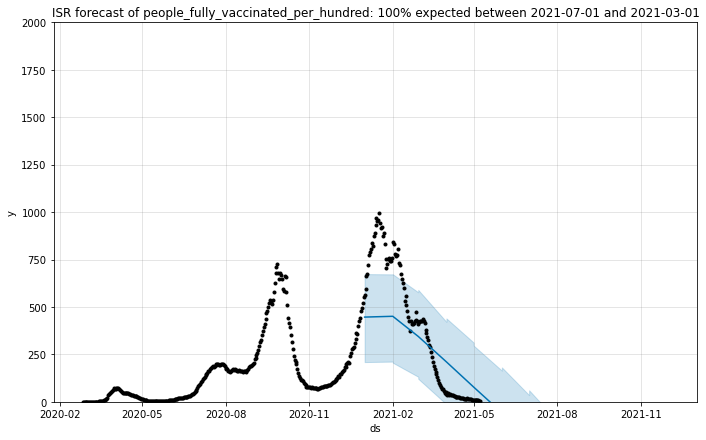

In [ ]:
#Forecast for Israel for infection rate
fcast('ISR', "false")

##Forecast For CHL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.123103   -0.284987    0.533628
1 2021-01-01  0.123103   -0.315768    0.556832
2 2021-02-01 -0.074951   -0.504316    0.350680
3 2021-02-01 -0.074951   -0.489092    0.324454
4 2021-03-01  0.198792   -0.235159    0.597450


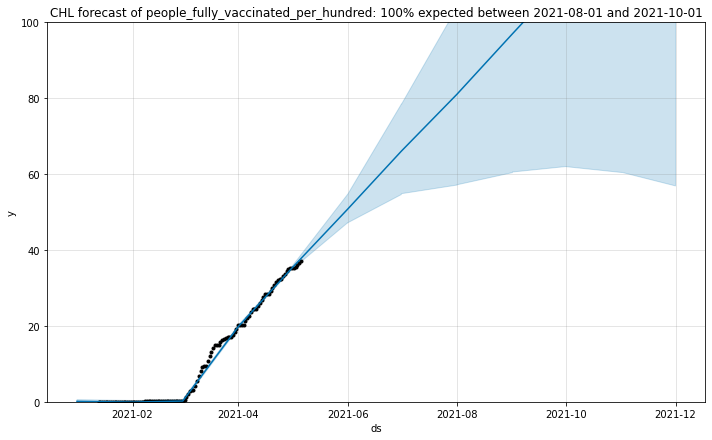

In [ ]:
fcast('CHL', "true")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  138.555923   85.528269  194.586905
1 2021-01-01  138.555923   80.095082  191.946518
2 2021-02-01  193.419337  141.635933  246.986085
3 2021-02-01  193.419337  134.453260  243.530212
4 2021-03-01  242.462759  185.602062  294.801179


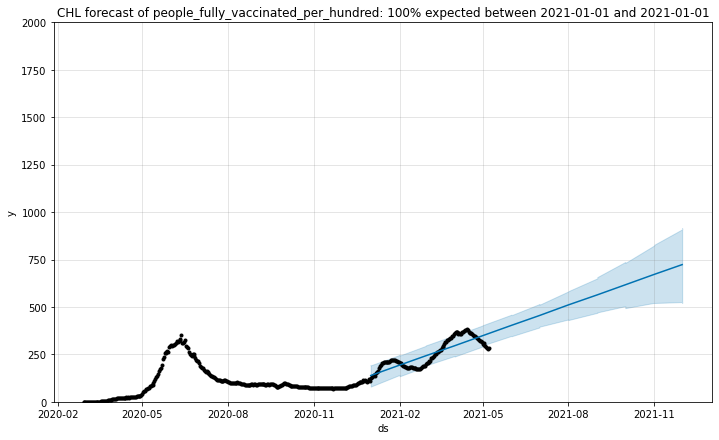

In [ ]:
fcast('CHL', "false")

##Forecast For USA

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01 -0.098833   -0.180713   -0.012961
1 2021-01-01 -0.098833   -0.184864   -0.011033
2 2021-02-01  1.794970    1.718510    1.880157
3 2021-02-01  1.794970    1.715815    1.874568
4 2021-03-01  7.623129    7.534158    7.703271


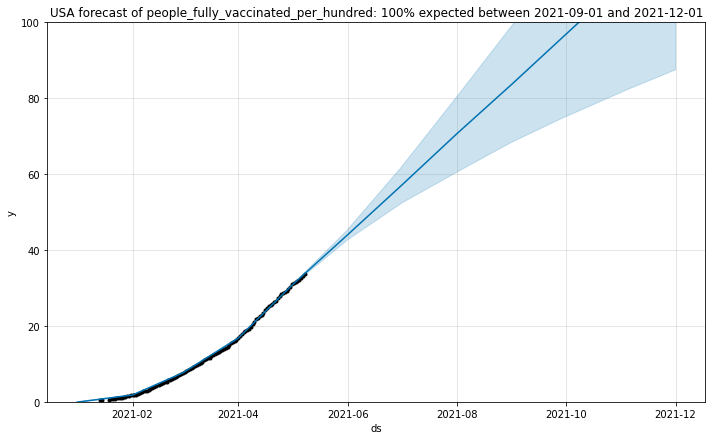

In [ ]:
fcast('USA','true')

Prediction for when USA will get fully vaccinated depending on the current rate
USA will be 100% vaccinated around end of 2021

---



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01  544.013711  453.006082  632.896215
1 2021-01-01  544.013711  452.095009  637.721611
2 2021-02-01  450.141699  356.957503  537.624704
3 2021-02-01  450.141699  363.571812  542.055720
4 2021-03-01  333.517614  234.480091  425.212417


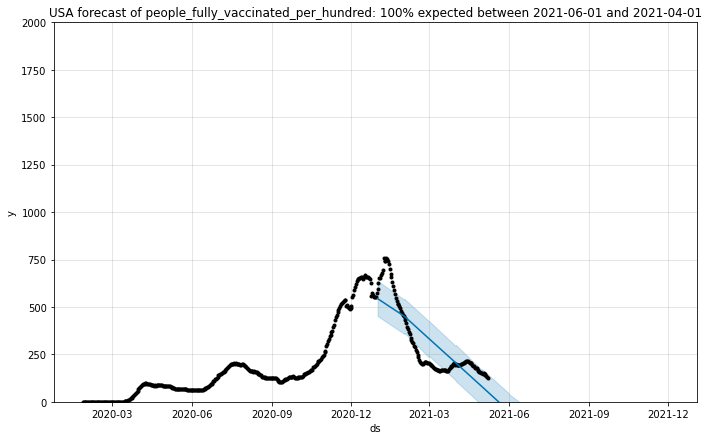

In [ ]:
fcast("USA","false")


##Forecast for Japan

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  -7.602899  -13.438928   -2.037851
1 2021-01-01  -7.602899  -13.211234   -1.970042
2 2021-02-01   4.179644   -1.222218    9.650742
3 2021-02-01   4.179644   -1.546603   10.358494
4 2021-03-01  14.821942    9.399552   19.807410


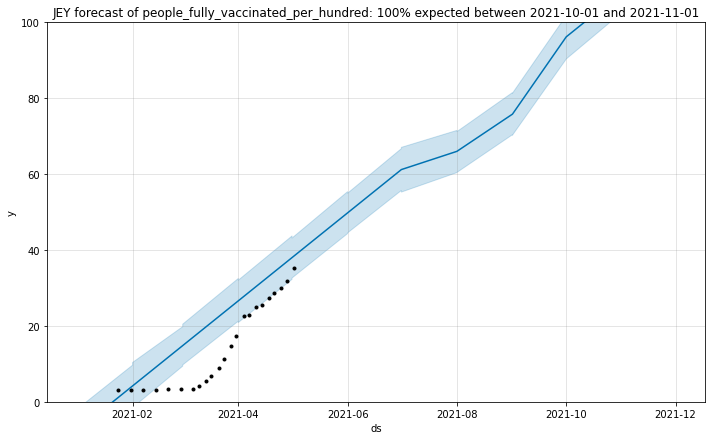

In [ ]:
fcast('JEY', "true")

#Prediction to calculate the number of weeks to acheive 70% of vaccination

##Plot per captia daily vaccination data

1. Define death and vaccination threshold and remove the locations below daily deaths and vacconation threshold
2. Define Tempory datasets: extract current and past date rows for each location
3. Define median vaccination

In [ ]:
#Plot per captia daily data
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
bar_transparency = 1
date_offset = 0
current_date = covid_dates[-1+date_offset]
past_date = covid_dates[-1*(num_days_back-date_offset)]
daily_deaths_threshold = 1 # include locations with more than this per million
daily_vax_threshold = 100

# Remove locations below daily deaths and vaccinations thresholds
covid_perCapita_daily_filtered_df = covid_perCapita_daily_df.query('new_deaths_smoothed_per_million > %d or new_vaccinations_smoothed_per_million > %d' %
                                                                 (daily_deaths_threshold, daily_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = covid_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = covid_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# median daily vaccinations
median_daily_vaxs = (temp_current_df['new_vaccinations_smoothed_per_million'].median())



##Plot the graph for captia daily data against death vs vaccinations and new cases vs vaccinations


1. Graph 1 : Daily Vaccinations/Million Compared to Daily Deaths/Million
2. Graph 2 : Daily Vaccinations/Million Compared to Daily Cases/Million

Text(45.0, 38084.7705, 'Deaths data is available on this date for 90 locations with population > 1000000, and deaths > 1/mil or vaccinations > 100/mil.\n    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n    Median number of vaccinations amongst these locations on this day: 4448/mil')

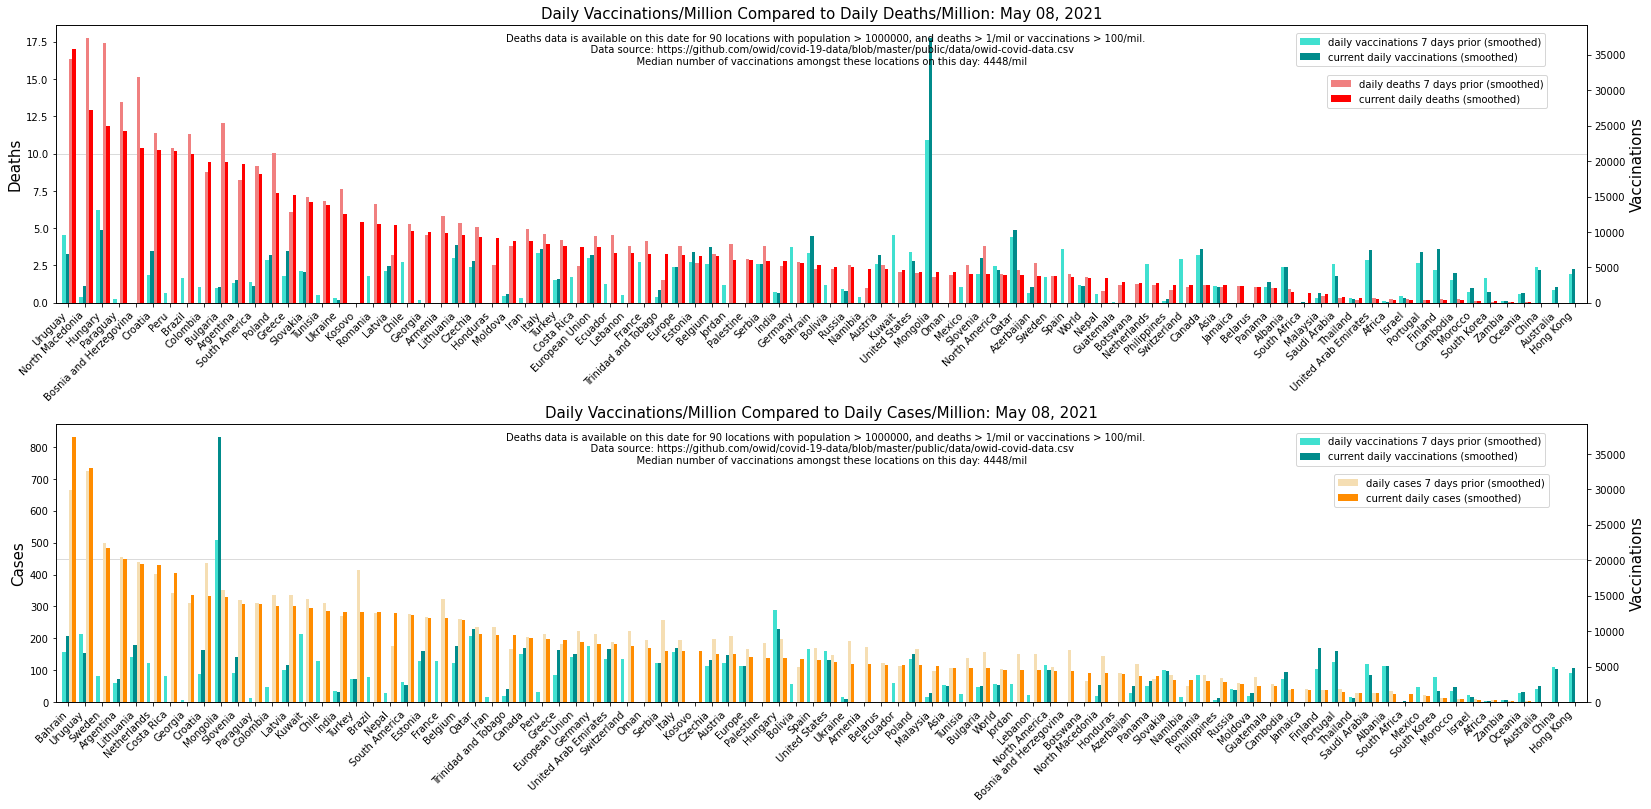

In [ ]:
# PER CAPITA DAILY DATA 

num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
bar_transparency = 1
date_offset = 0
current_date = covid_dates[-1+date_offset]
past_date = covid_dates[-1*(num_days_back-date_offset)]
daily_deaths_threshold = 1 # include locations with more than this per million
daily_vax_threshold = 100

# Remove locations below daily deaths and vaccinations thresholds
covid_perCapita_daily_filtered_df = covid_perCapita_daily_df.query('new_deaths_smoothed_per_million > %d or new_vaccinations_smoothed_per_million > %d' %
                                                                 (daily_deaths_threshold, daily_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = covid_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = covid_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# median daily vaccinations
median_daily_vaxs = int(temp_current_df['new_vaccinations_smoothed_per_million'].median())

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths > %d/mil or vaccinations > %d/mil.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n\
    Median number of vaccinations amongst these locations on this day: %d/mil" \
     % (len([i[0] for i in temp_current_df.index]), min_population, daily_deaths_threshold, daily_vax_threshold, median_daily_vaxs)

# death/vaccinations (top)
# sort temp datasets by "new_deaths_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_deaths_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top2.set_xlim([-0.5,len(x_vals)])
ax_top2.set_ylabel('Vaccinations', fontsize=15)
ax_top1.set_ylabel('Deaths', fontsize=15)
ax_top2.set_title("Daily Vaccinations/Million Compared to Daily Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals + bar_width*2, temp_past_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=1)
ax_top1.bar(x_vals + bar_width*3, temp_current_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=1)
ax_top1.hlines(ax_top1.get_yticks()[-1]/2, ax_top1.get_xlim()[0], ax_top1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_top2.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_top2.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_top2.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_top1.legend(['daily deaths %d days prior (smoothed)'%num_days_back, 'current daily deaths (smoothed)'], loc=[0.83, 0.7])
ax_top2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, va='top', ha='center', fontsize=10)

# cases/vaccinations (bottom)
# sort temp datasets by "new_cases_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_cases_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom2.set_ylabel('Vaccinations', fontsize=15)
ax_bottom1.set_ylabel('Cases', fontsize=15)
ax_bottom2.set_title("Daily Vaccinations/Million Compared to Daily Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals + bar_width*2, temp_past_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='wheat', width=bar_width, zorder=1)
ax_bottom1.bar(x_vals + bar_width*3, temp_current_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width, zorder=1)
ax_bottom1.hlines(ax_bottom1.get_yticks()[-1]/2, ax_bottom1.get_xlim()[0], ax_bottom1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_bottom2.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_bottom2.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_bottom2.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_bottom1.legend(['daily cases %d days prior (smoothed)'%num_days_back, 'current daily cases (smoothed)'], loc=[0.835, 0.7])
ax_bottom2.text(ax_bottom2.get_xlim()[1]/2, ax_bottom2.get_ylim()[1]*0.97, inclusion_string, va='top',  ha='center', fontsize=10)



## Plot graph for CUMULATIVE DAILY DATA 

Text(52.5, 1234829.4, 'Deaths data is available on this date for 105 locations with population > 1000000, and deaths > 100/mil or vaccinations > 10/mil.\n    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n    Median vaccinations done for these locations to date: 269800/mil')

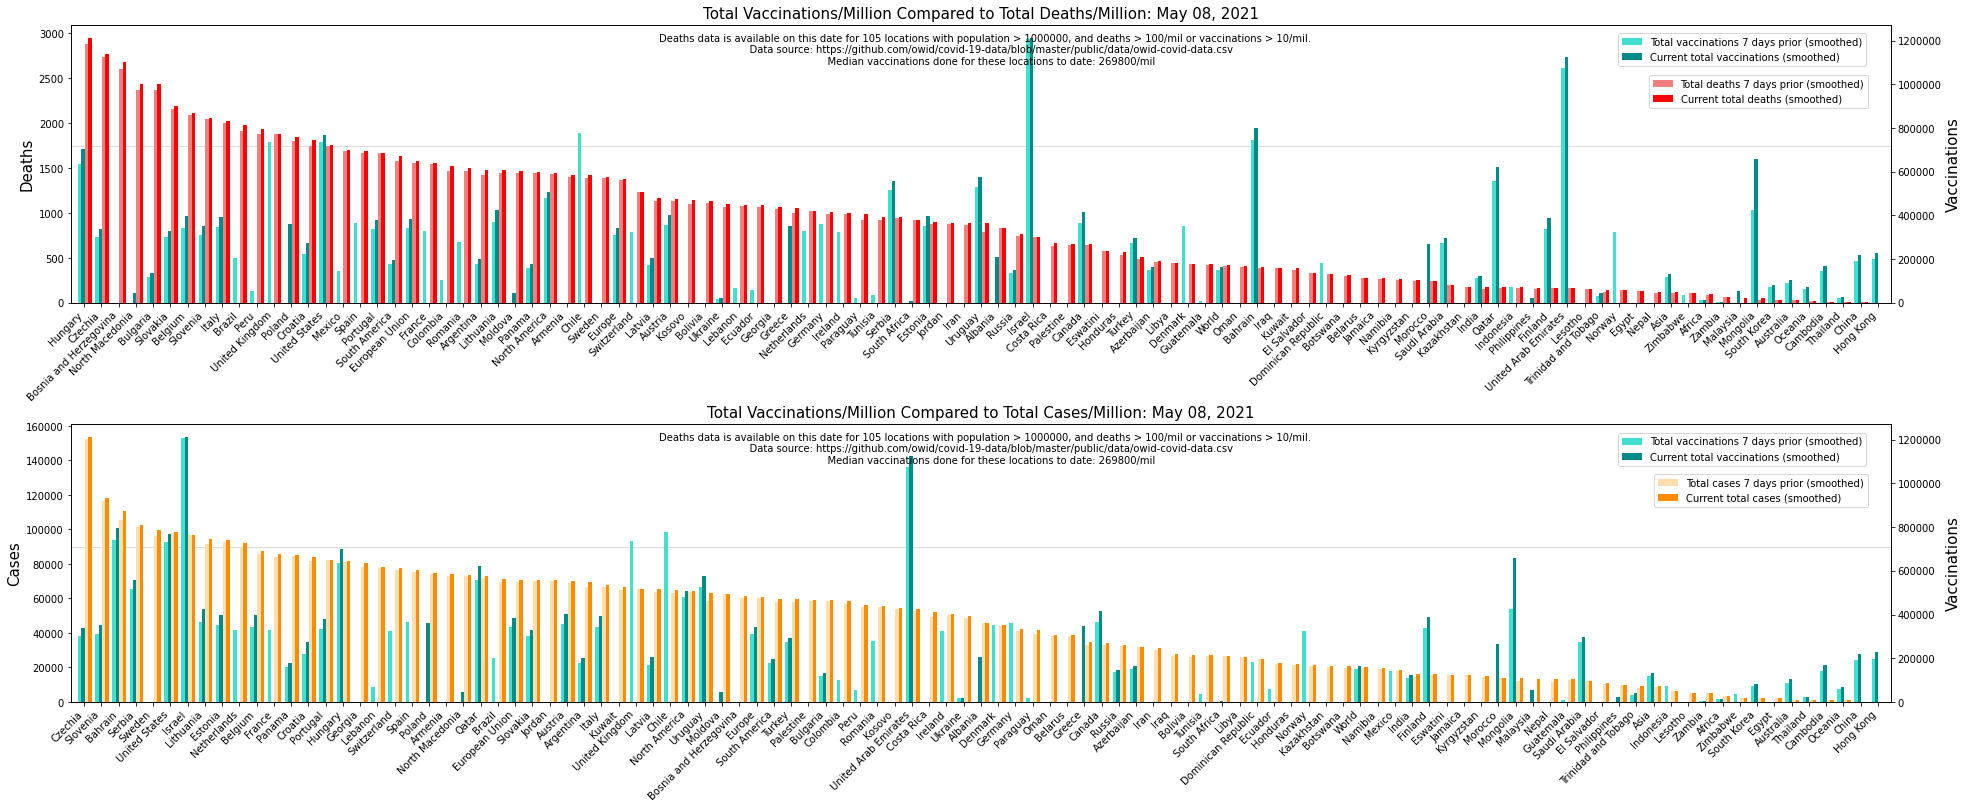

In [ ]:
# CUMULATIVE DAILY DATA #
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
date_offset = 0
current_date = covid_dates[-1+date_offset]
past_date = covid_dates[-1*(num_days_back-date_offset)]
cumulative_deaths_threshold = 100 # include locations with more than this per million
cumulative_vax_threshold = 10

# Remove locations below daily deaths and vaccinations thresholds
covid_perCapita_cumulative_filtered_df = covid_perCapita_cumulative_df.query('total_deaths_per_million > %d or total_vaccinations_per_million > %d' %
                                                                 (cumulative_deaths_threshold, cumulative_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = covid_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = covid_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# median total vaccinations
median_total_vaxs = int(temp_current_df['total_vaccinations_per_million'].median())

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
axs[0].ticklabel_format(scilimits=[0, 10])
axs[1].ticklabel_format(scilimits=[0, 10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths > %d/mil or vaccinations > %d/mil.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n\
    Median vaccinations done for these locations to date: %d/mil" \
     % (len([i[0] for i in temp_current_df.index]), min_population, cumulative_deaths_threshold, cumulative_vax_threshold, median_total_vaxs)

# death/vaccinations (top)
# sort temp datasets by deaths
temp_current_df = temp_current_df.sort_values("total_deaths_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top2.ticklabel_format(scilimits=[0, 10])
ax_top2.set_ylabel('Vaccinations', fontsize=15)
ax_top1.set_ylabel('Deaths', fontsize=15)
ax_top1.set_title("Total Vaccinations/Million Compared to Total Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals + bar_width*2, temp_past_df["total_deaths_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=1)
ax_top1.bar(x_vals + bar_width*3, temp_current_df["total_deaths_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=1)
ax_top1.hlines(ax_top1.get_yticks()[-1]/2, ax_top1.get_xlim()[0], ax_top1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_top2.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_top2.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_top2.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_top1.legend(['Total deaths %d days prior (smoothed)'%num_days_back, 'Current total deaths (smoothed)'], loc=[0.867, 0.7])
ax_top2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, ha='center', va='top', fontsize=10, zorder=2)

# cases/vaccinations (bottom)
# sort temp datasets by cases
temp_current_df = temp_current_df.sort_values("total_cases_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
#plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom2.ticklabel_format(scilimits=[0, 10])
ax_bottom2.set_ylabel('Vaccinations', fontsize=15)
ax_bottom1.set_ylabel('Cases', fontsize=15)
ax_bottom1.set_title("Total Vaccinations/Million Compared to Total Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals + bar_width*2, temp_past_df["total_cases_per_million"], alpha=bar_transparency, color='navajowhite', width=bar_width)
ax_bottom1.bar(x_vals + bar_width*3, temp_current_df["total_cases_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width)
ax_bottom1.hlines(ax_bottom1.get_yticks()[-1]/2, ax_bottom1.get_xlim()[0], ax_bottom1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_bottom2.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width)
ax_bottom2.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width)
ax_bottom2.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_bottom1.legend(['Total cases %d days prior (smoothed)'%num_days_back, 'Current total cases (smoothed)'], loc=[0.87, 0.7])
ax_bottom2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, ha='center', va='top', fontsize=10, zorder=2)

## Calculate number of weeks to full vaccination

Enter the country name United States


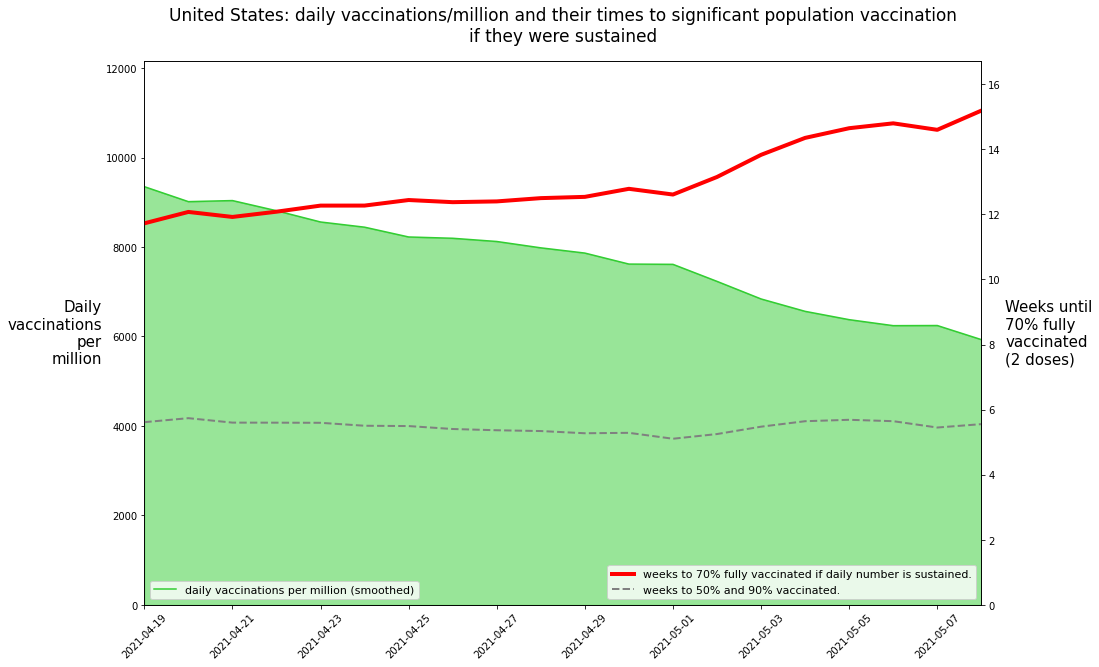

In [ ]:
#Calculate number of weeks to full vaccination
location = input('Enter the country name ')
last_n_days = 21
HI_threshold = 0.7
times_to_HI = []
lowerInterval_HI_times = []
upperInterval_HI_times = []
daily_vaxs = []
dates = []


# select relevant columns for location
location_daily_vaxPerMil_df = preProcessed_covid_df.loc[location, ['new_vaccinations_smoothed_per_million', 'date', 'total_vaccinations_per_million', 
                                                                       'people_fully_vaccinated_per_million']]
# get date of first daily vaccination value
first_vax_date = location_daily_vaxPerMil_df.set_index('date').notna().idxmax()
location_daily_vaxPerMil_df = location_daily_vaxPerMil_df[location_daily_vaxPerMil_df['date'] >= first_vax_date[0]]

# get times_to_HI figures
for i in range(last_n_days):
  if location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['new_vaccinations_smoothed_per_million'] > 0:
    daily_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['new_vaccinations_smoothed_per_million']
    total_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['total_vaccinations_per_million']
    fully_vaxxed_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['people_fully_vaccinated_per_million']
    if math.isnan(fully_vaxxed_fig):
      fully_vaxxed_fig = 0
    daily_vaxs.append(daily_fig)
    dates.append(location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['date'])
    # append lists for plotting
    times_to_HI.append(((HI_threshold*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7))
    lowerInterval_HI_times.append((((HI_threshold-0.2)*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7)) 
    upperInterval_HI_times.append((((HI_threshold+0.2)*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7))

# Vaccination breakdowns
percent_single_dose = (location_daily_vaxPerMil_df['total_vaccinations_per_million'].tail(1) - location_daily_vaxPerMil_df['people_fully_vaccinated_per_million'].tail(1)*2)/10000
percent_double_dose = location_daily_vaxPerMil_df['people_fully_vaccinated_per_million'].tail(1)/10000

# plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('%s: daily vaccinations/million and their times to significant population vaccination\nif they were sustained' % location, fontsize=17, pad=20)
ax2 = ax1.twinx()
# ax1: daily vaxs
ax1.set_ylabel("Daily\nvaccinations\nper\nmillion", fontsize=15,rotation='horizontal', ha='right', va='center')
ax1.fill_between(dates, daily_vaxs, color='limegreen', alpha=0.5, zorder=-1)
ax1.set_ylim([0, max(daily_vaxs)*1.3])
ax1.set_xlim([dates[0], dates[-1]])
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45) 
ax1.plot(dates,daily_vaxs, color='limegreen',zorder=1)
ax1.legend(['daily vaccinations per million (smoothed)'], loc='lower left', fontsize=11)
# ax2: weeks to HI
ax2.plot(dates, times_to_HI, color='red', linewidth=4)
ax2.set_ylim([0, max([x for x in times_to_HI if np.isnan(x) == False])*1.1])
ax2.plot(dates, upperInterval_HI_times, color='grey', linewidth=2, linestyle='--')
ax2.plot(dates, lowerInterval_HI_times, color='grey', linewidth=2, linestyle='--')
ax2.set_ylabel("Weeks until\n%d%% fully\nvaccinated\n(2 doses)" % int(100*HI_threshold), fontsize=15, rotation='horizontal', ha='left', va='center')
ax2.legend(['weeks to %d%% fully vaccinated if daily number is sustained.' % int(HI_threshold*100), 'weeks to %d%% and %d%% vaccinated.' % (int((HI_threshold-0.2)*100+1), int((HI_threshold+0.2)*100+1))],
           fontsize=11, loc='lower right')
if not math.isnan(percent_double_dose): 
  ax2.text(dates[int(len(dates)/2)], ax2.get_ylim()[1]*0.97, 'To date: %0.1f%% of population given two doses +\n%0.1f%% given one dose' % (percent_double_dose, percent_single_dose),
         ha='center', va='top', fontsize=14)
